# Tutorial on Wasserstein Flow Matching for spatial niches

Here we present a tutorial on how to run WFM for generation & intepretation of high-dimentional niches from spatial transcriptomics data

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.95"

import jax
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

import sklearn.decomposition
import sklearn.neighbors
import scipy.sparse


In [2]:
from wassersteinflowmatching.wasserstein import WassersteinFlowMatching

# Load Spatial Data

Annotated data can be downloaded from https://dp-lab-data-public.s3.amazonaws.com/WassersteinFM/st_data.h5ad 

In [3]:
st_data = sc.read('/data/peer/DoronHaviv/merFISHCortex/st_data_envi_sst.h5ad')
#st_data = sc.read('st_data.h5ad')

In this tutorial, we'll be focusing on somatostatin (Sst) interneurons and generation of their spatial niches conditioned on their phenotype. First, we will visualize the relationship between Sst subtype and cortical depth:

In [4]:
sst_palette = {'Myh8': (0.65098, 0.482353, 0.72549, 1.0),
 'Th': (0.92549, 0.0, 0.466667, 1.0),
 'Calb2': (0.933333, 0.72549, 0.72549, 1.0),
 'Hpse': (0.607843, 0.894118, 1.0, 1.0),
 'Crh': (0.560784, 0.478431, 0.0, 1.0),
 'Hspe': (0.0, 0.294118, 0.0, 1.0),
 'Chodl': (0.92549, 0.0, 0.466667, 1.0),
 'Crhr2': (0.352941, 0.0, 0.643137, 1.0),
 'Etv1': (1.0, 0.447059, 0.4, 1.0),
 'Chold': (0.368627, 0.494118, 0.4, 1.0)}

sst_subtype_order = ['Calb2', 'Etv1', 'Hpse', 'Myh8', 'Chodl', 'Hspe', 'Crhr2', 'Crh', 'Th']

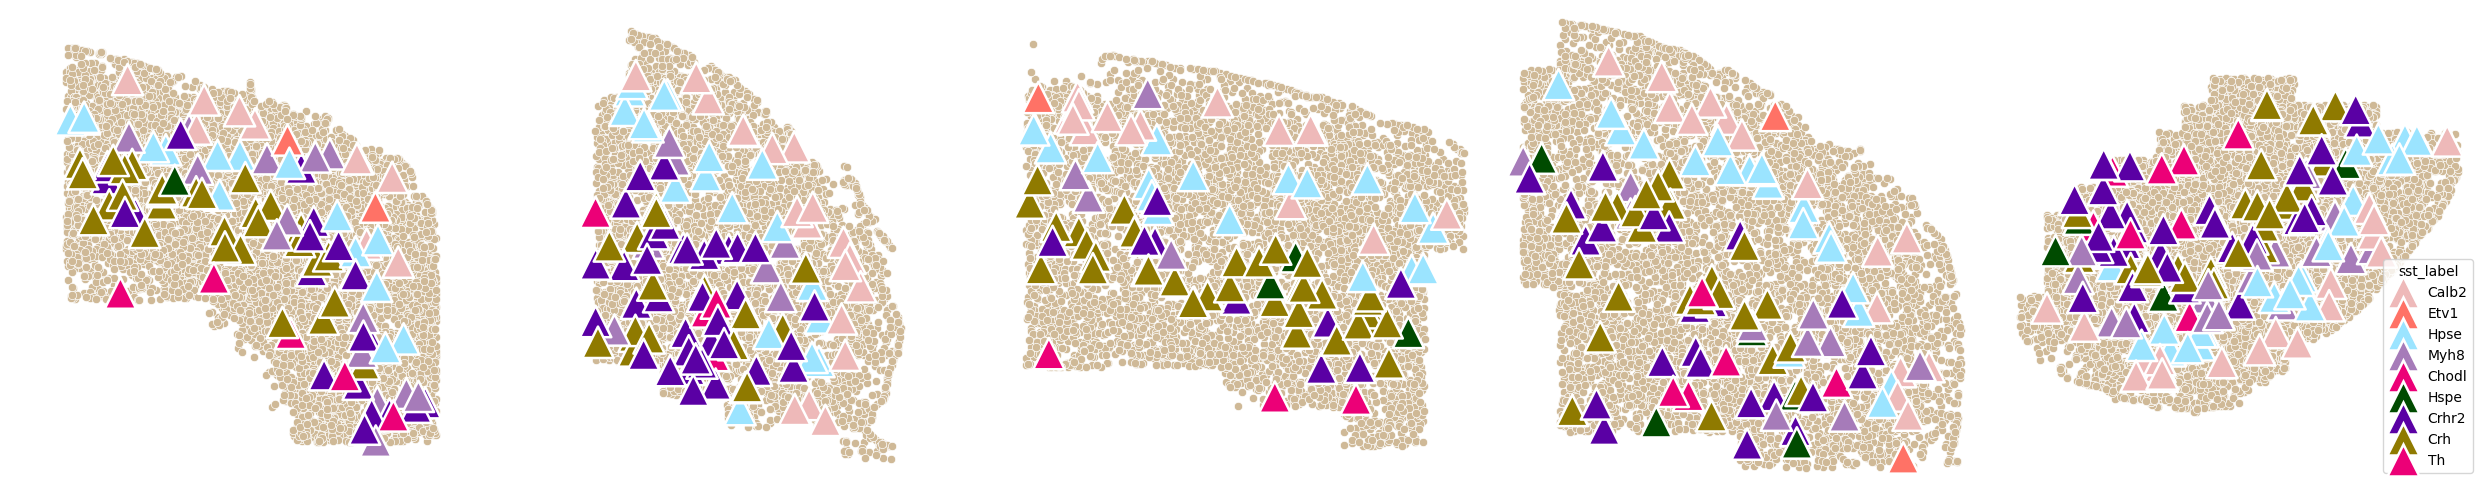

In [5]:
fig = plt.figure(figsize=(25, 5))
for ind, batch in enumerate(['mouse1_slice162', 'mouse1_slice40', 'mouse2_slice229', 'mouse1_slice71', 'mouse1_slice102']):
    


    plt.subplot(1, 5, 1+ ind)

    st_data_batch = st_data[st_data.obs['batch'] == batch]
    sst_data_batch = st_data_batch[st_data_batch.obs['cell_type'] == 'Sst']

    sns.scatterplot(x = st_data_batch.obsm['spatial'][:, 0], y = st_data_batch.obsm['spatial'][:, 1],  color = (207/255,185/255,151/255, 1))

    sns.scatterplot(x = sst_data_batch.obsm['spatial'][:, 0], y = sst_data_batch.obsm['spatial'][:, 1], marker = '^',
                    hue = sst_data_batch.obs['sst_label'], s = 512,  palette=sst_palette, 
                    hue_order = sst_subtype_order, 
                    legend = ind==4)


    plt.axis('off')
    plt.axis('equal')
    plt.tight_layout()
plt.show()

## Construction of Niche Point-Clouds

After some pre-processing, we will aggregate the k=16 nearest-neighours of every cell to construct niche defining point-cloud based on the top 16 principal components:

In [6]:
sc.pp.normalize_total(st_data, target_sum=np.median(st_data.X.sum(axis = 1)))
sc.pp.log1p(st_data)

In [7]:
st_data.uns['pc_transform'] = sklearn.decomposition.PCA(n_components=16).fit(st_data.X)
st_data.obsm['X_pca'] = st_data.uns['pc_transform'].transform(st_data.X)

### Get Niches

In [8]:
def GetNiche(spatial_data, k, spatial_key = 'spatial', batch_key = -1, rep = None):
    

    """
    Wrapper to compute niche covariance based on cell expression and location

    Args:
        spatial_data (anndata): anndata with spatial data, with obsm 'spatial' indicating spatial location of spot/segmented cell
        kNN (int): number of nearest neighbours to define niche
        spatial_key (str): obsm key name with physical location of spots/cells (default 'spatial')
        batch_key (str): obs key name of batch/sample of spatial data (default -1)
        MeanExp (np.array): expression vector to shift niche covariance with
        weighted (bool): if True, weights covariance by spatial distance|
    Return:
        CovMats: niche covariance matrices
        kNNGraphIndex: indices of nearest spatial neighbours per cell
    """
    
    if(rep is None):
        ExpData = spatial_data.X.astype('float32')
    else:
        ExpData = np.asarray(spatial_data.obsm[rep]).astype('float32')
    
    if(batch_key == -1 or batch_key not in spatial_data.obs.columns):        
        #kNNGraph = sklearn.neighbors.radius_neighbors_graph(spatial_data.obsm[spatial_key], radius=r, mode='distance', n_jobs=-1).tocoo()
        kNNGraph = sklearn.neighbors.kneighbors_graph(spatial_data.obsm[spatial_key], n_neighbors=k, mode='distance', n_jobs=-1).tocoo()
        kNNGraph = scipy.sparse.coo_matrix((np.ones_like(kNNGraph.data), (kNNGraph.row, kNNGraph.col)), shape=kNNGraph.shape).tocsr()
        NicheMat = np.split(ExpData[kNNGraph.indices], kNNGraph.indptr[1:-1], axis = 0)    

    else:
        batch =  spatial_data.obs[batch_key]
        NicheMat = np.asarray(np.arange(ExpData.shape[0])).astype('object')
        for val in np.unique(batch):
            val_ind = np.where(batch == val)[0]
            data = spatial_data[batch == val]
            batch_knn = sklearn.neighbors.kneighbors_graph(data.obsm[spatial_key], n_neighbors=k, mode='distance', n_jobs=-1).tocoo()
            batch_knn = scipy.sparse.coo_matrix((np.ones_like(batch_knn.data), (batch_knn.row, batch_knn.col)), shape=batch_knn.shape).tocsr()
            batch_niche_mat = np.split(ExpData[val_ind][batch_knn.indices], batch_knn.indptr[1:-1], axis = 0)
            
            NicheMat[val_ind] = batch_niche_mat
        
    return(NicheMat)

In [ ]:
st_data.obsm['niche_mat'] = np.asarray(GetNiche(st_data, k = 16, rep = 'X_pca', batch_key = 'batch'))

max_abs = np.max([np.max(np.abs(niche)) for niche in st_data.obsm['niche_mat'] ])
st_data.obsm['niche_mat']  = [niche/max_abs for niche in st_data.obsm['niche_mat'] ]

## Subset to Sst

In [10]:
st_data_sst = st_data[st_data.obs['cell_type'] == 'Sst']

# Run Wasserstein Flow Matching

Train Wasserstein Flow Matching on Sst niche point-clouds conditioned on Sst subtype:

In [11]:
FlowMatchingModel = WassersteinFlowMatching(point_clouds = st_data_sst.obsm['niche_mat'],
                                            labels = np.asarray(st_data_sst.obs['sst_label']).astype('str'),
                                            wasserstein_eps = 0.01, wasserstein_lse = False)

Initializing WassersteinFlowMatching
Using row_iter map with 200 iterations and 0.01 epsilon


Train Model & Plot loss curve

In [12]:

FlowMatchingModel.train(batch_size = 64,
                        training_steps = 100000, 
                        warmup_steps = 1000)

: nan:   3%|▎         | 2528/100000 [01:18<50:32, 32.14it/s] 


KeyboardInterrupt: 

In [ ]:
loss_smooth = np.convolve(np.log(FlowMatchingModel.losses), np.ones(100)/100, mode='valid')
plt.plot(loss_smooth)

# Generate Samples

Set Initial Key

In [ ]:
key = jax.random.PRNGKey(0)

Run Flow for 1000 timesteps

In [ ]:

subkey,key = jax.random.split(key)
generated_samples, sample_weights = FlowMatchingModel.generate_samples(num_samples = 16,
                                                            size = 1000,
                                                            timesteps = 1000,
                                                            key = subkey)

Plot resulting point clouds

In [ ]:
fig = plt.figure(figsize=(20, 20)) 
for i in range(16):
    ax = fig.add_subplot(4,4, 1+i, projection='3d')
    ax.scatter(generated_samples[-1][i][:, 2], - generated_samples[-1][i][:, 0],  generated_samples[-1][i][:, 1], c = generated_samples[-1][i][:, 1])
    ax.axis('equal')
plt.show()